In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_score
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [3]:
categories = [
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'misc.forsale', 
    'talk.politics.misc',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.religion.misc',
    'alt.atheism',
    'soc.religion.christian'
]

df = fetch_20newsgroups(subset='all', categories=categories, 
                            shuffle=False, remove=('headers', 'footers', 'quotes'))

In [4]:
labels = df.target
true_k = len(np.unique(labels))
true_k

20

In [5]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [6]:
for i, name in enumerate(df.target_names): # Order
    print(f"Label {i}: {name}")

Label 0: alt.atheism
Label 1: comp.graphics
Label 2: comp.os.ms-windows.misc
Label 3: comp.sys.ibm.pc.hardware
Label 4: comp.sys.mac.hardware
Label 5: comp.windows.x
Label 6: misc.forsale
Label 7: rec.autos
Label 8: rec.motorcycles
Label 9: rec.sport.baseball
Label 10: rec.sport.hockey
Label 11: sci.crypt
Label 12: sci.electronics
Label 13: sci.med
Label 14: sci.space
Label 15: soc.religion.christian
Label 16: talk.politics.guns
Label 17: talk.politics.mideast
Label 18: talk.politics.misc
Label 19: talk.religion.misc


In [7]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [8]:
data = pd.DataFrame(df.data, columns=['text'])
data['target'] = df.target
data['text'] = data['text'].apply(lemmatize_text)

In [9]:
data.head()

,text,target
0,morgan and guzman will have era 's 1 run highe...,9
1,"Well , I just got my Centris 610 yesterday . I...",4
2,Archive-name : cryptography-faq/part10 Last-mo...,11
3,To the best of my knowledge there are n't any ...,4
4,I think that domestication will change behavio...,0


In [10]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2) ## Corpus is in English
X = vectorizer.fit_transform(data['text'])

In [11]:
X.shape

(18846, 49381)

In [19]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, random_state=10)
km.fit(X)

KMeans(max_iter=100, n_clusters=20, random_state=10)

In [20]:
print("Homogeneity: %0.3f" % homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % completeness_score(labels, km.labels_))
print("Silhouette Score: %0.3f" % silhouette_score(X, km.labels_, sample_size=10000))

Homogeneity: 0.280
Completeness: 0.342
Silhouette Score: 0.005


In [21]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: dsl n3jxp cadre chastity geb intellect skepticism shameful banks pitt
Cluster 1: people think just say like doe thing wa ha know
Cluster 2: thanks mail know advance does hi looking email info address
Cluster 3: card driver video monitor vga color diamond bus mode ati
Cluster 4: file windows window program dos format font version use manager
Cluster 5: drug doctor patient msg disease food ha test medical treatment
Cluster 6: bike ride wa riding dod just motorcycle rider like mile
Cluster 7: drive scsi disk ide hard controller floppy problem cd meg
Cluster 8: israel armenian israeli jews arab armenians turkish wa people jewish
Cluster 9: wa did year think said time just know people like
Cluster 10: gun government law people right crime batf weapon wa state
Cluster 11: key chip clipper encryption escrow phone algorithm government bit secure
Cluster 12: 00 10 11 25 50 15 20 12 30 13
Cluster 13: different class auto cobb like revolver tax edu just wa
Cluster 14: game team player 

#### Visualization:

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [23]:
def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = km.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [24]:
def makeImage(frequencies):
    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)
    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

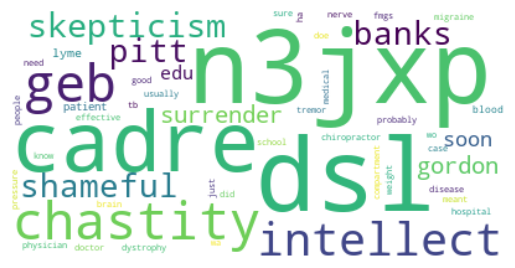

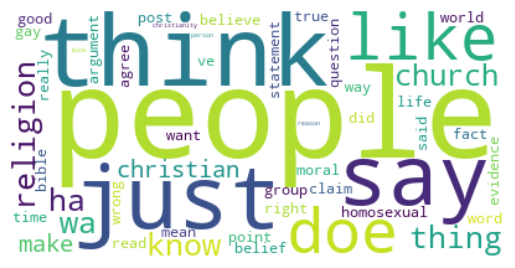

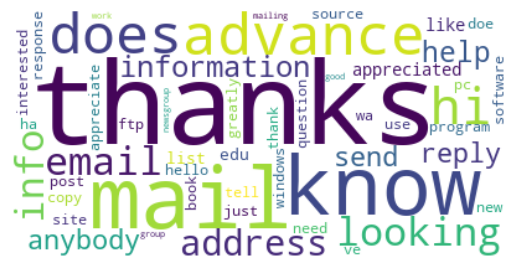

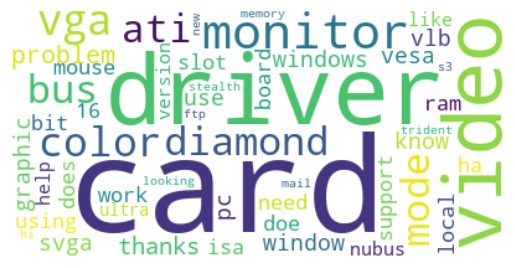

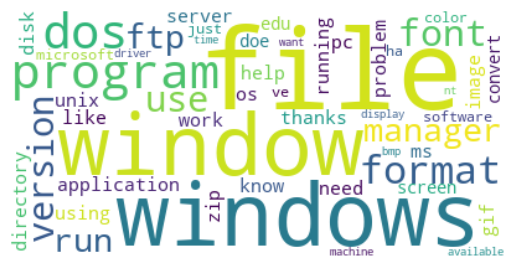

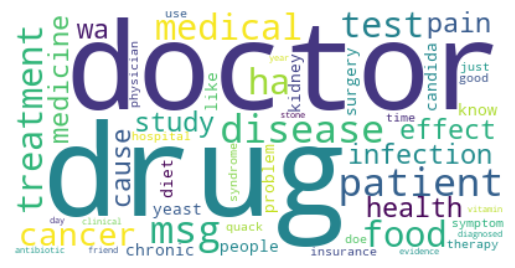

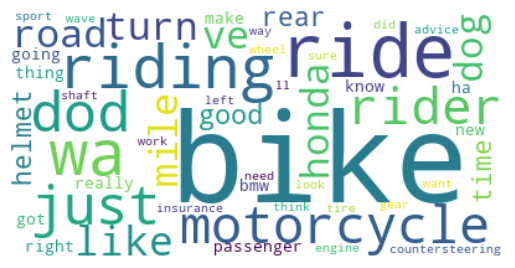

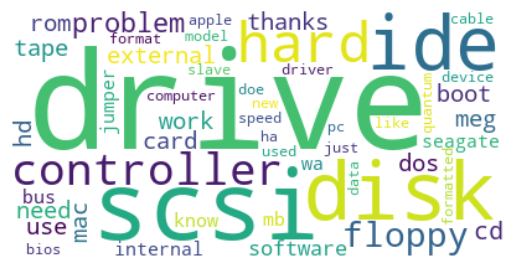

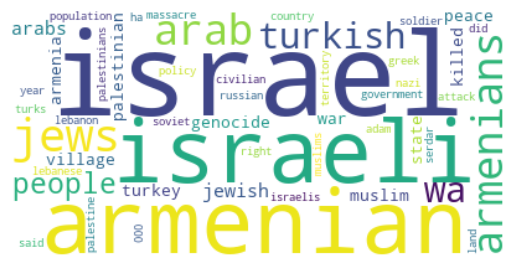

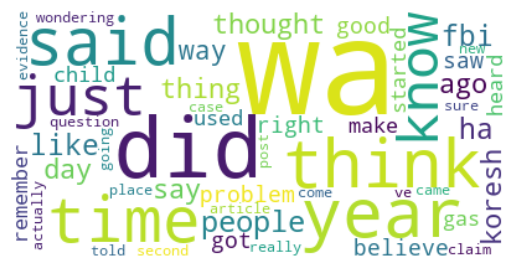

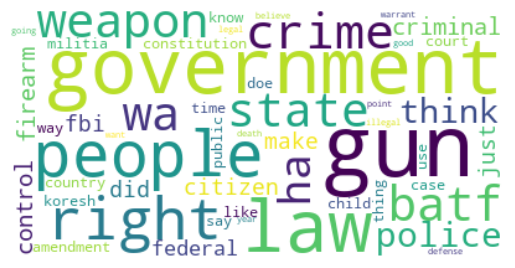

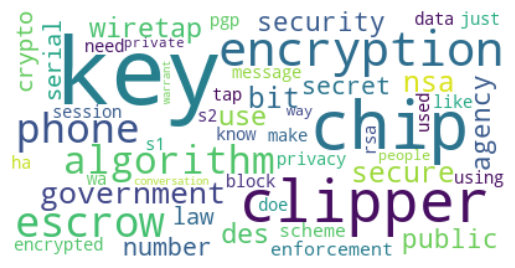

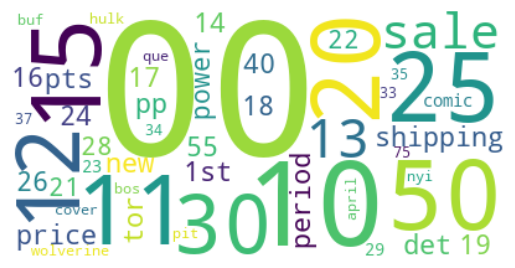

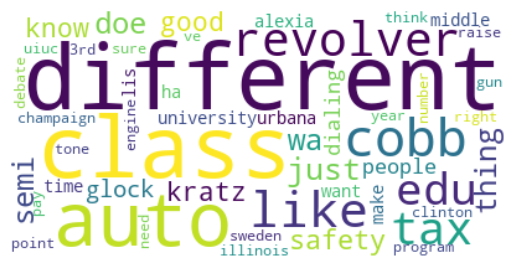

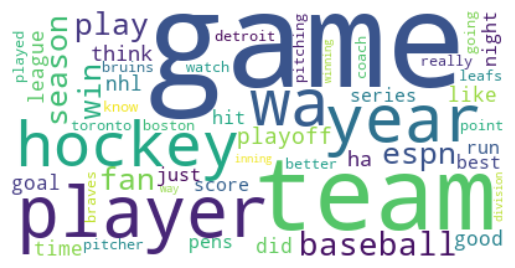

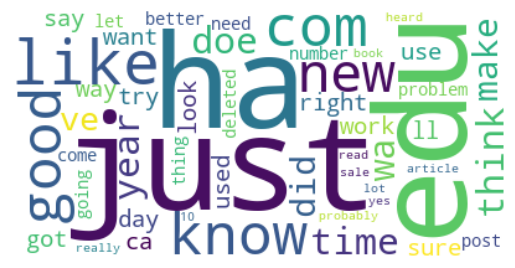

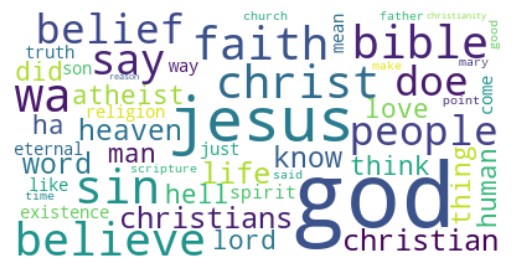

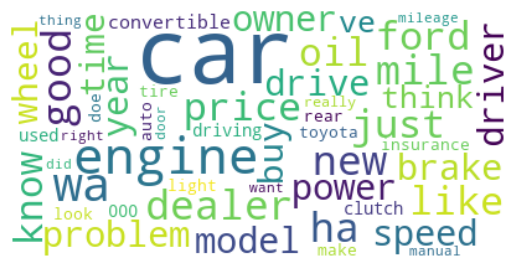

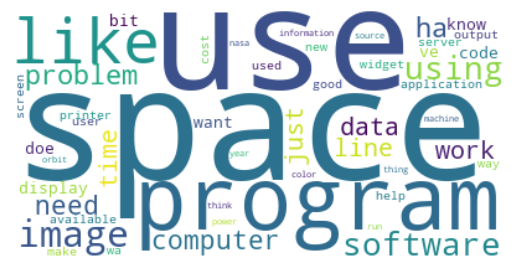

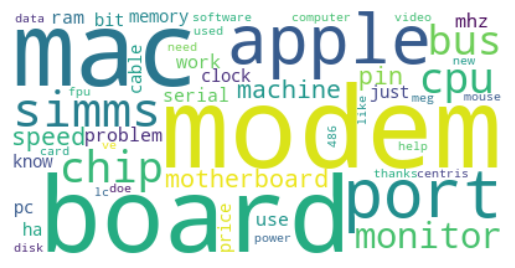

In [25]:
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()

In [26]:
len(data)

18846

In [27]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame with 'text' and 'target' columns
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)

# Get the list of English stopwords
stop_words = stopwords.words('english')

# Use TfidfVectorizer with stopwords removal
# max_df=0.5 to remove terms that appear in more than 50% of the documents.
vectorizer = TfidfVectorizer(max_features=10000, stop_words=stop_words, max_df=0.5)  # Adjust max_features as needed
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
# Create datasets
train_dataset = NewsDataset(X_train_vectorized, y_train)
test_dataset = NewsDataset(X_test_vectorized, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class NewsClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [30]:
input_size = X_train_vectorized.shape[1]  # Number of features
model = NewsClassifier(input_size, true_k)

In [31]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.3f}')

Epoch [1/10], Loss: 2.752
Epoch [2/10], Loss: 2.154
Epoch [3/10], Loss: 2.282
Epoch [4/10], Loss: 2.824
Epoch [5/10], Loss: 2.080
Epoch [6/10], Loss: 2.179
Epoch [7/10], Loss: 2.079
Epoch [8/10], Loss: 2.323
Epoch [9/10], Loss: 2.319
Epoch [10/10], Loss: 2.078


In [32]:
from sklearn.metrics import accuracy_score

model.eval()  
predictions = []
with torch.no_grad():  
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        predictions.extend(predicted.numpy())

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.679


In [33]:
classes = [n for n in df.target_names]
classes

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [34]:
example_sentence = 'The new Honda civic gives great mileage and is extremely smooth on the road!'

vectorized_sentence = vectorizer.transform([example_sentence]).toarray()
prediction = model(torch.tensor(vectorized_sentence, dtype=torch.float32))
pred_class_index = torch.argmax(prediction, dim=1).item()
pred_class_name = classes[pred_class_index]

print(f"Your sentence belongs to the '{pred_class_name}' class.")

Your sentence belongs to the 'rec.autos' class.


In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_vectorized, y_train)

LogisticRegression()

In [36]:
pred1 = lr.predict(X_test_vectorized)
pred1

array([10,  3, 17, ...,  1, 13,  7], dtype=int64)

In [37]:
accuracy_score(y_test, pred1)

0.7222811671087533

In [43]:
test_sentence = 'My macbook I bought 5 years ago, still works fine. Apple makes great products.'
vect_sentence = vectorizer.transform([test_sentence]).toarray()
pred_index = lr.predict(vect_sentence).item()
pred_name = classes[pred_index]

print(f"Your sentence belongs to the '{pred_name}' class.")

Your sentence belongs to the 'comp.sys.mac.hardware' class.


In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_vectorized, y_train)

RandomForestClassifier()

In [39]:
pred2 = rfc.predict(X_test_vectorized)
pred2

array([10,  3, 17, ...,  1, 13,  7], dtype=int64)

In [40]:
accuracy_score(y_test, pred2)

0.6472148541114059